In [ ]:
!pip install xgboost seaborn scikit-learn tensorflow pandas matplotlib --quiet

# Cyber Threat Detection - Full Machine Learning Pipeline
Includes supervised learning, neural networks, clustering, and anomaly detection with full preprocessing and plots.

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, silhouette_score, adjusted_rand_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [4]:

def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    df.drop(columns=[col for col in ['Flow ID', 'Timestamp'] if col in df.columns], inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df['Label'] = LabelEncoder().fit_transform(df['Label'])
    return df

def preprocess_features(df):
    X = df.drop('Label', axis=1)
    y = df['Label']
    feature_names = X.columns
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, feature_names

df = load_and_clean_data("data/friday_afternoon.csv")
X_scaled, y, feature_names = preprocess_features(df)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [5]:

def plot_roc_curve(model, X_test, y_test, title):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(title)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid()
    plt.legend()
    plt.show()

def plot_learning(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='f1', n_jobs=-1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train F1')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Val F1')
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid()
    plt.show()


## Supervised Learning - Logistic Regression

In [ ]:

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()
plot_roc_curve(lr, X_test, y_test, "ROC - Logistic Regression")
plot_learning(lr, X_scaled, y, "Learning Curve - Logistic Regression")


## Supervised Learning - Logistic Regression - Scratch

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     29321
           1       0.98      1.00      0.99     38393

    accuracy                           0.99     67714
   macro avg       0.99      0.98      0.99     67714
weighted avg       0.99      0.99      0.99     67714



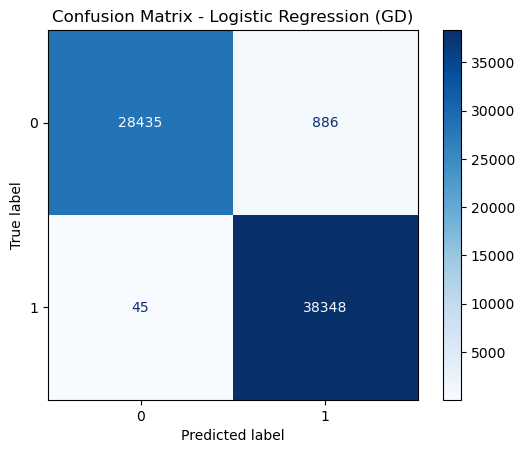

In [6]:

def sigmoid(z): return 1 / (1 + np.exp(-z))
def logistic_regression_gd(X, y, lr=0.1, epochs=1000):
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    weights = np.zeros(X.shape[1])
    for _ in range(epochs):
        z = np.dot(X, weights)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        weights -= lr * gradient
    return weights
def predict_gd(X, weights):
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    return (sigmoid(np.dot(X, weights)) > 0.5).astype(int)

weights = logistic_regression_gd(X_train, y_train)
y_pred = predict_gd(X_test, weights)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (GD)")
plt.show()


## Supervised Learning - Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29321
           1       1.00      1.00      1.00     38393

    accuracy                           1.00     67714
   macro avg       1.00      1.00      1.00     67714
weighted avg       1.00      1.00      1.00     67714



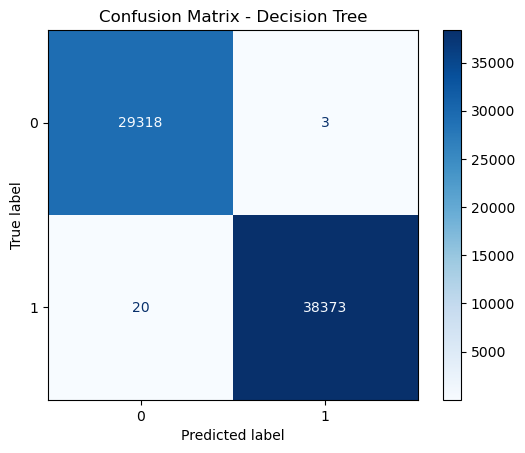

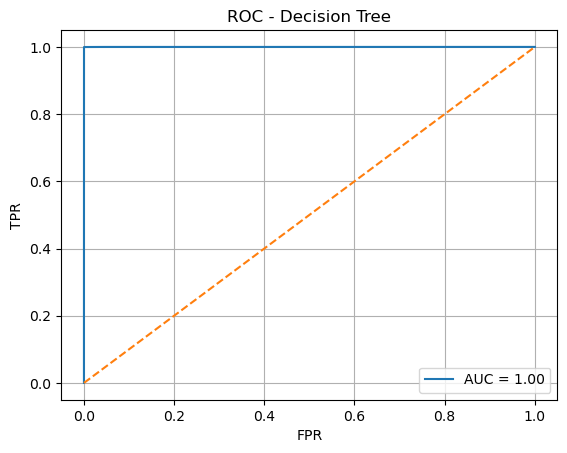

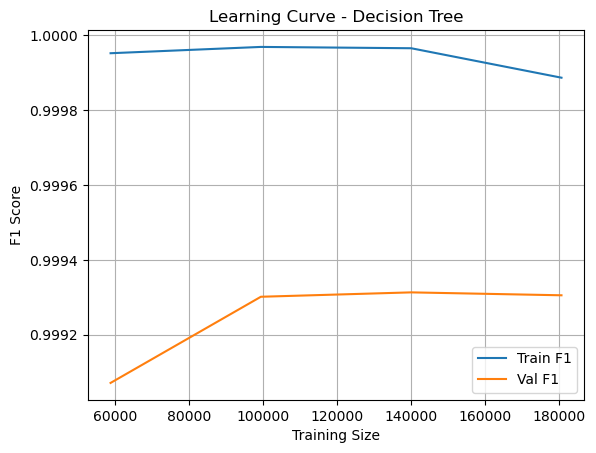

In [7]:

dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.show()
plot_roc_curve(dt, X_test, y_test, "ROC - Decision Tree")
plot_learning(dt, X_scaled, y, "Learning Curve - Decision Tree")


## Supervised Learning - Random Forest

In [ ]:

rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()
plot_roc_curve(rf, X_test, y_test, "ROC - Random Forest")
plot_learning(rf, X_scaled, y, "Learning Curve - Random Forest")


## Supervised Learning - XGBoost

In [ ]:

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()
plot_roc_curve(xgb, X_test, y_test, "ROC - XGBoost")
plot_learning(xgb, X_scaled, y, "Learning Curve - XGBoost")


## Neural Networks - 3 Models

In [ ]:

architectures = [
    ("Model A: ReLU 2-layer", 'relu', [64, 32]),
    ("Model B: tanh 2-layer", 'tanh', [64, 32]),
    ("Model C: ReLU 3-layer", 'relu', [128, 64, 32])
]

for name, act_fn, layers in architectures:
    print(f"\n--- {name} ---")
    model = Sequential()
    model.add(Dense(layers[0], input_shape=(X_scaled.shape[1],), activation=act_fn))
    model.add(Dropout(0.3))
    for units in layers[1:]:
        model.add(Dense(units, activation=act_fn))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=512, verbose=0)
    y_proba = model.predict(X_test)
    y_bin = (y_proba > 0.5).astype(int)

    print(classification_report(y_test, y_bin))
    ConfusionMatrixDisplay.from_predictions(y_test, y_bin, cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve - Neural Network Models")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()


## K-Means Clustering

In [ ]:

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_scaled)
print(f"ARI: {adjusted_rand_score(y, labels):.4f}")
print(f"Silhouette Score: {silhouette_score(X_scaled, labels):.4f}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set2')
plt.title("KMeans PCA Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


## Gaussian Anomaly Detection (Elliptic Envelope)

In [ ]:

model = EllipticEnvelope(contamination=0.1)
model.fit(X_scaled[y == 0])
y_pred = model.predict(X_scaled)
y_bin = (y_pred == -1).astype(int)

print(classification_report(y, y_bin))
ConfusionMatrixDisplay.from_predictions(y, y_bin, cmap='Blues')
plt.title("Confusion Matrix - Gaussian Anomaly Detection")
plt.show()

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_bin, palette='Set1', alpha=0.6)
plt.title("PCA - Anomaly Detection")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()
